# Heart Disease Prediction

This notebook is based on the following notebook from the Udemy course "Complete ML & Data Science Bootcamp 2023": [Zero to Mastery ML - Heart Disease Classification](https://github.com/mrdbourke/zero-to-mastery-ml/blob/master/section-3-structured-data-projects/end-to-end-heart-disease-classification.ipynb) 

Here we are following the same methodology but using a different dataset to compare to the dataset used by the original project. 
The data set(s) are collected from the [UCI ML Repository](https://archive.ics.uci.edu/dataset/45/heart+disease).

### **Table of Contents**
  -  [1. Problem Definition](#problem-definition)
  -  [2. Data](#data)
  -  [3. Evaluation](#evaluation)
  -  [4. Feature Selection](#feature-selection)
  -  [5. Modeling](#Modeling)

## 1. Problem Definition


The goal is to predict whether a patient has heart disease or not given a set of features. This is a binary classification problem since there are only two possible results: 
  -  1 = Heart Disease
  -  0 = No Heart Disease

## 2. Data


The original notebook used the Cleaveland dataset only: [UCI ML Repository](https://archive.ics.uci.edu/dataset/45/heart+disease). 

Here we will be using that as well as Hungarian, Switzerland, and VA data sets. The full dataset contains 76 features but we will only be using 13 plus the target variable. These features are defined in the Features section.

## 3. Evaluation

There are a few metric goal:
  -  Reach at least 95% _Accuracy_
  -  Minimize _False Negatives_
  -  Maximize _True Positives_
  -  Maximize _True Negatives_

## 4. Feature Selection


We will start with the following features:
  -  **age**:  age in years
  -  **sex**:  sex (1 = male; 0 = female)
  -  **cp**:  chest pain type
     -   1 = typical angina
     -   2 = atypical angina
     -   3 = non-anginal pain
     -   4 = asymptomatic
  -  **trestbps**:  resting blood pressure (in mm Hg on admission to the
     -   anything above 130-140 is typically cause for concern
        hospital)
  -  **chol**:  serum cholestoral in mg/dl
     -   serum = LDL + HDL + .2 * triglycerides
     -   above 200 is cause for concern
  -  **fbs**:  fasting blood sugar > 120 mg/dl (1 = true; 0 = false)
     -   '>126' mg/dL signals diabetes
  -  **restecg**:  resting electrocardiographic results
     -   0 = normal
     -   1 = having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
         -    signals abnormal heart beat
     -   2 = showing probable or definite left ventricular hypertrophy by Estes' criteria (enlarged heart)
  -  **thalach**:  maximum heart rate achieved
  -  **exang**:  exercise induced angina (1 = yes; 0 = no)
  -  **oldpeak**:  ST depression induced by exercise relative to rest
  -  **slope**:  the slope of the peak exercise ST segment
     -   1 = upsloping
     -   2 = flat
     -   3 = downsloping
  -  **ca**:  number of major vessels (0-3) colored by flourosopy (more is better)
  -  **thal**:  3 = normal; 6 = fixed defect; 7 = reversable defect
  -  **num (aka target)**: the predicted attribute
  
In a separate experiment, it was found that the following 9 features produced better results:

    * cp        * age       
    * exang     * fbs      
    * slope     * restecg
    * thal      * oldpeak      
    * ca


## 5. Modelling

### Importing all required packages

In [34]:
## Import all Packages that will be used
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8-darkgrid')

## Display plots in the notebook
%matplotlib inline

## Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

## Model evaluators
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import RocCurveDisplay

## Print last run time
import time
print(f"Last updated: {time.asctime()}")

Last updated: Fri Sep 15 23:21:30 2023


### Import Data Sets

In [20]:
## Import Data Sets
df_va = pd.read_csv("data/processed.va.data")
df_cl = pd.read_csv("data/processed.cleveland.data")
df_hung = pd.read_csv("data/reprocessed.hungarian.data")
df_swl = pd.read_csv("data/processed.switzerland.data")
df_original = pd.read_csv("data/heart-disease.csv")

## Concatenate to one DF
df_all = pd.concat([df_va, df_cl, df_hung, df_swl])

# Replace the target values 2,3,4 with 1 to make it binary.
df_all_binary = df_all
df_all_binary.target.replace([2,3,4], 1, inplace=True)
target_counts = df_all_binary.target.value_counts()

print(df_va.shape, df_cl.shape, df_hung.shape, df_swl.shape, target_counts)

(200, 14) (303, 14) (294, 14) (123, 14) target
1    509
0    411
Name: count, dtype: int64


### Data Pre-processing

#### Initial exploration

In [3]:
## Data Exploration
df_va.head(3)
#df_cl.head(3)
#df_hung.head(3)
#df_swl.head(3)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,4,140.0,260.0,0.0,1,112.0,1.0,3.0,2.0,NaN,NaN,2
1,44,1,4,130.0,209.0,0.0,1,127.0,0.0,0.0,NaN,NaN,NaN,0
2,60,1,4,132.0,218.0,0.0,1,140.0,1.0,1.5,3.0,NaN,NaN,2


In [4]:
#df_va.info()
#df_cl.info()
#df_hung.info()
#df_swl.info()

#### Custom fuctions

In [5]:
## From the info above, we see some columns are strings not ints
def delete_NaN_rows(df):
    index_to_delete = []
    for i in df.itertuples():
        index = i[0]
        cols = df_swl.columns
        i = list(i)
        del i[0]
        #print(i)

        nan_count=0
        key=0
        for data in i:
            #print("Key: ", key)
            #print("data: ", data)
            if pd.isna(data) or pd.isnull(data) or data == 'nan':
                #print("Is NaN")
                nan_count += 1
            key += 1
            #break;
        #print(f"Nan Count for {index}: ", nan_count)
        if nan_count >= 5:
            index_to_delete.append(index)

        #break;

    print("Rows to Delete: ", index_to_delete)
    
    return df.drop(index_to_delete)



#### Delete NaN rows

In [8]:
# For each DF, remove the rows with excessive NaN values
#df_va
#df_cl
#df_hung
#df_swl
print(df_all_binary.shape)
df_all_binary_rows = delete_NaN_rows(df_all_binary)
print(df_all_binary.shape)

(920, 14)
Rows to Delete:  [13, 23, 26, 29, 30, 36, 38, 44, 51, 57, 58, 60, 68, 69, 72, 77, 87, 89, 94, 96, 109, 110, 111, 112, 113, 114, 115, 119, 120, 124, 129, 133, 136, 137, 141, 142, 144, 145, 147, 149, 155, 158, 159, 161, 163, 164, 167, 168, 174, 181, 185, 196, 198, 289, 2, 39, 117]
(920, 14)


#### Check NaN Values
After deleting rows with more than 5 NaN cols

In [12]:
## Check NaN values
print("df_all_binary_rows: ", len(df_all_binary_rows))
print(df_all_binary_rows.isna().sum())
print("\ndf_original:", len(df_original))
print(df_original.isna().sum())

df_all_binary_rows:  718
age           0
sex           0
cp            0
trestbps      3
chol         24
fbs          71
restecg       2
thalach       0
exang         0
oldpeak       5
slope       221
ca          469
thal        360
target        0
dtype: int64

df_original: 303
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64


#### Count NaN vals All
Counting NaN vals for entire New data set (not with delted rows)

In [13]:
## Count NA vals
print(df_all_binary.isna().sum())

# The columns with Nan values:
# trestbps  3    resting blood pressure (in mm Hg) -> MEAN
# chol      27   Cholesterol level in mg/dlin mg/dl -> MEAN
# fbs       88   fasting blood sugar > 120 mg/dl    -> DROP
                    # 0 = blood sugar < 120 mg/dl
                    # 1 = blood sugar > 120 mg/dl
# oldpeak   6    ST depression induced by exercise relative to rest -> MEAN
# slope     253  the slope of the peak exercise ST segment -> DROP
                    # 1 = upsloping
                    # 2 = flat
                    # 3 = downsloping
# ca        553  number of major vessels (0-3) colored by flourosopy -> 9 or DROP
# thal      432  3 = normal; 6 = fixed defect; 7 = reversable defect -> DROP

age           0
sex           0
cp            0
trestbps     59
chol         30
fbs          90
restecg       2
thalach      55
exang        55
oldpeak      62
slope       309
ca          610
thal        486
target        0
dtype: int64


#### Create 2 DF
df_rows_del = df_all_binary with rows of column (ca,thal, slope, fbs) Nan vals removed

df_cols_del = df_all_binary with columns ca,thal, slope, fbs

In [42]:
# Creating 2 DFs
df_rows_del = df_all_binary.dropna(subset=["fbs", "thal", "ca", "slope"])
df_cols_del = df_all_binary.drop(["fbs", "thal", "ca", "slope", "restecg", "exang"], axis=1)
# trestbps, chol, oldpeak, thalach -> mean

print(f"Rows Removed:  len={len(df_rows_del)}\n", df_rows_del.isna().sum())
print(f"\nCols Removed:  len={len(df_cols_del)}\n",df_cols_del.isna().sum())

Rows Removed:  len=299
 age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

Cols Removed:  len=920
 age          0
sex          0
cp           0
trestbps    59
chol        30
thalach     55
oldpeak     62
target       0
dtype: int64


#### View Target counts for all data sets

In [16]:
print("All Data: ", df_all_binary.target.value_counts())
print("\ndf_original: ", df_original.target.value_counts())
print("\nRows Removed:  \n", 
      df_rows_del.target.value_counts())
print("\nCols Removed:  \n",
      df_cols_del.target.value_counts())

All Data:  target
1    509
0    411
Name: count, dtype: int64

df_original:  target
1    165
0    138
Name: count, dtype: int64

Rows Removed:  
 target
0    160
1    139
Name: count, dtype: int64

Cols Removed:  
 target
1    509
0    411
Name: count, dtype: int64


#### Crosstab of Target vs thal

In [22]:
crosstab_thal_all = pd.crosstab(df_all_binary.target, df_all_binary.thal)
crosstab_thal_row = pd.crosstab(df_rows_del.target, df_rows_del.thal)
crosstab_thal_original = pd.crosstab(df_original.target, df_original.thal)

print("All Data: \n", crosstab_thal_all)
print("\nRows Removed:  \n", crosstab_thal_row)
print("\ndf_original: ", crosstab_thal_original)

All Data: 
 thal    3.0  6.0  7.0
target               
0       138   11   38
1        58   35  154

Rows Removed:  
 thal    3.0  6.0  7.0
target               
0       127    6   27
1        37   12   90

df_original:  thal    0   1    2   3
target                
0       1  12   36  89
1       1   6  130  28


#### Crosstab of Target vs sex

In [24]:
crosstab_sex_all = pd.crosstab(df_all_binary.target, df_all_binary.sex)
crosstab_sex_row = pd.crosstab(df_rows_del.target, df_rows_del.sex)
crosstab_sex_col = pd.crosstab(df_cols_del.target, df_cols_del.sex)
crosstab_sex_original = pd.crosstab(df_original.target, df_original.sex)

print("All Data: \n", crosstab_sex_all)
print("\nRows Removed:  \n", crosstab_sex_row)
print("\nCols Removed:  \n", crosstab_sex_col)
print("\ndf_original: \n", crosstab_sex_original)

All Data: 
 sex     0.0  1.0
target          
0       144  267
1        50  459

Rows Removed:  
 sex     0.0  1.0
target          
0        71   89
1        25  114

Cols Removed:  
 sex     0.0  1.0
target          
0       144  267
1        50  459

df_original: 
 sex      0    1
target         
0       24  114
1       72   93


#### Crosstab of Target vs cp

In [26]:
crosstab_cp = pd.crosstab(df_all_binary.cp, df_all_binary.target)
crosstab_cp_row = pd.crosstab(df_rows_del.target, df_rows_del.cp)
crosstab_cp_col = pd.crosstab(df_cols_del.target, df_cols_del.cp)
crosstab_cp_original = pd.crosstab(df_original.target, df_original.cp)

print("All Data: \n", crosstab_sex_all)
print("\nRows Removed:  \n", crosstab_cp_row)
print("\nCols Removed:  \n", crosstab_cp_col)
print("\ndf_original: \n", crosstab_cp_original)

All Data: 
 sex     0.0  1.0
target          
0       144  267
1        50  459

Rows Removed:  
 cp      1.0  2.0  3.0  4.0
target                    
0        16   40   65   39
1         7    9   18  105

Cols Removed:  
 cp      1.0  2.0  3.0  4.0
target                    
0        26  150  131  104
1        20   24   73  392

df_original: 
 cp        0   1   2   3
target                 
0       104   9  18   7
1        39  41  69  16


#### Data Plots

/tmp/ipykernel_8783/3145802437.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(ax2.get_xticks(), rotation = 0)


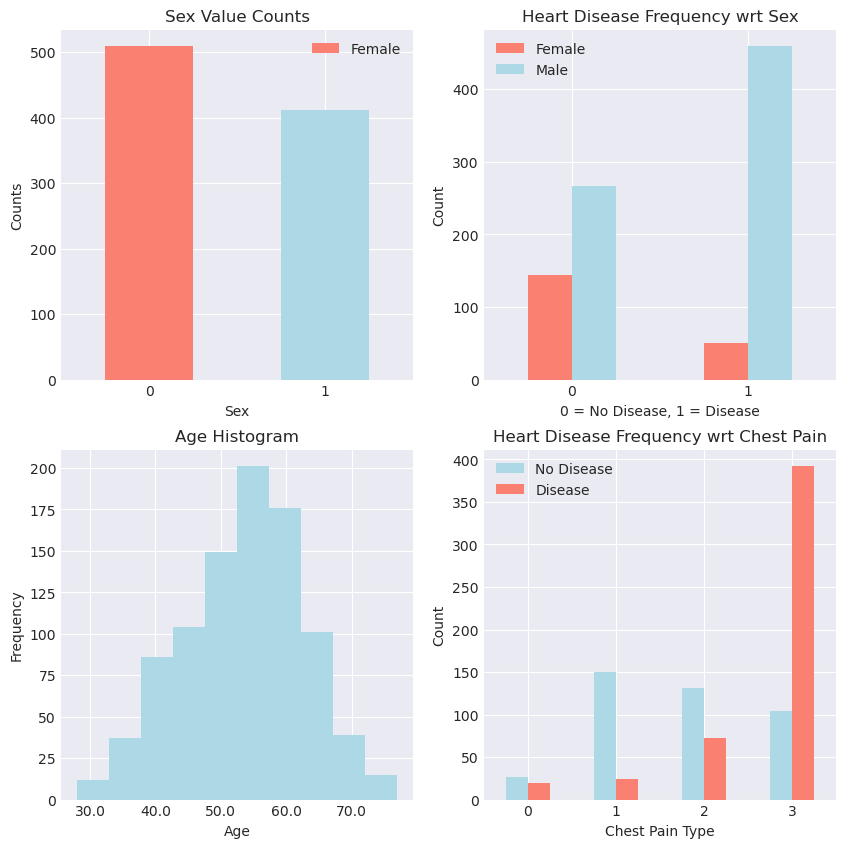

In [57]:
## Create some plots
fig, ((ax0, ax1), (ax2,ax3)) = plt.subplots(nrows=2, 
                                        ncols=2, 
                                        figsize=(10,10))

target_counts.plot(kind="bar", ax=ax0,
                   title="Sex Value Counts",
                   xlabel="Sex",
                   ylabel="Counts",
                   legend=True,
                   color=["salmon", "lightblue"])
crosstab_sex.plot(kind="bar", ax=ax1,
                  title="Heart Disease Frequency wrt Sex",
                  xlabel="0 = No Disease, 1 = Disease",
                  ylabel="Count",
                  legend=True,
                  color=["salmon", "lightblue"])
df_all_binary.age.plot(kind="hist", ax=ax2,
                  title="Age Histogram",
                  xlabel="Age",
                  ylabel="Frequency",
                  color=["lightblue"])
crosstab_cp.plot(kind="bar", ax=ax3,
                  title="Heart Disease Frequency wrt Chest Pain",
                  xlabel="Chest Pain Type",
                  ylabel="Count",
                  legend=True,
                  color=["lightblue", "salmon"])

ax0.set_xticklabels(ax0.get_xticks(), rotation = 0)
ax0.legend(labels=["Female", "Male"])
ax1.set_xticklabels(ax1.get_xticks(), rotation = 0)
ax1.legend(labels=["Female", "Male"])
ax2.set_xticklabels(ax2.get_xticks(), rotation = 0)
ax3.set_xticklabels(ax3.get_xticks(), rotation = 0)
ax3.legend(labels=["No Disease", "Disease"]);

#### Data Correlation

In [28]:
# Find the correlation between our independent variables
corr_matrix_all = df_all_binary.corr()
corr_matrix_row = df_rows_del.corr()
corr_matrix_col = df_cols_del.corr()
corr_matrix_original = df_original.corr()

corr_matrix_all

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
age,1.000000,0.056889,0.166245,0.244253,-0.086234,0.233726,0.212719,-0.365778,0.201626,0.258243,0.155032,0.311194,0.137298,0.282700
sex,0.056889,1.000000,0.170392,0.001087,-0.197281,0.089191,-0.015612,-0.179320,0.181420,0.103930,0.125154,0.045905,0.373927,0.307284
cp,0.166245,0.170392,1.000000,0.025075,-0.132576,0.039838,0.031101,-0.349189,0.419384,0.244245,0.202989,0.213678,0.313150,0.471712
trestbps,0.244253,0.001087,0.025075,1.000000,0.092853,0.160235,0.098857,-0.104899,0.152328,0.161908,0.063387,0.110024,0.107555,0.106233
chol,-0.086234,-0.197281,-0.132576,0.092853,1.000000,0.024847,0.116494,0.236121,-0.034557,0.047734,-0.059276,0.040043,-0.179903,-0.230583
fbs,0.233726,0.089191,0.039838,0.160235,0.024847,1.000000,0.132347,-0.053386,0.029176,0.055277,0.092142,0.122318,0.105871,0.142565
restecg,0.212719,-0.015612,0.031101,0.098857,0.116494,0.132347,1.000000,0.053120,0.032331,0.118297,-0.014771,0.098393,-0.040084,0.063867
thalach,-0.365778,-0.179320,-0.349189,-0.104899,0.236121,-0.053386,0.053120,1.000000,-0.356439,-0.151174,-0.360622,-0.256214,-0.327360,-0.394503
exang,0.201626,0.181420,0.419384,0.152328,-0.034557,0.029176,0.032331,-0.356439,1.000000,0.392492,0.319424,0.149447,0.340737,0.463619
oldpeak,0.258243,0.103930,0.244245,0.161908,0.047734,0.055277,0.118297,-0.151174,0.392492,1.000000,0.421184,0.250485,0.254391,0.385528


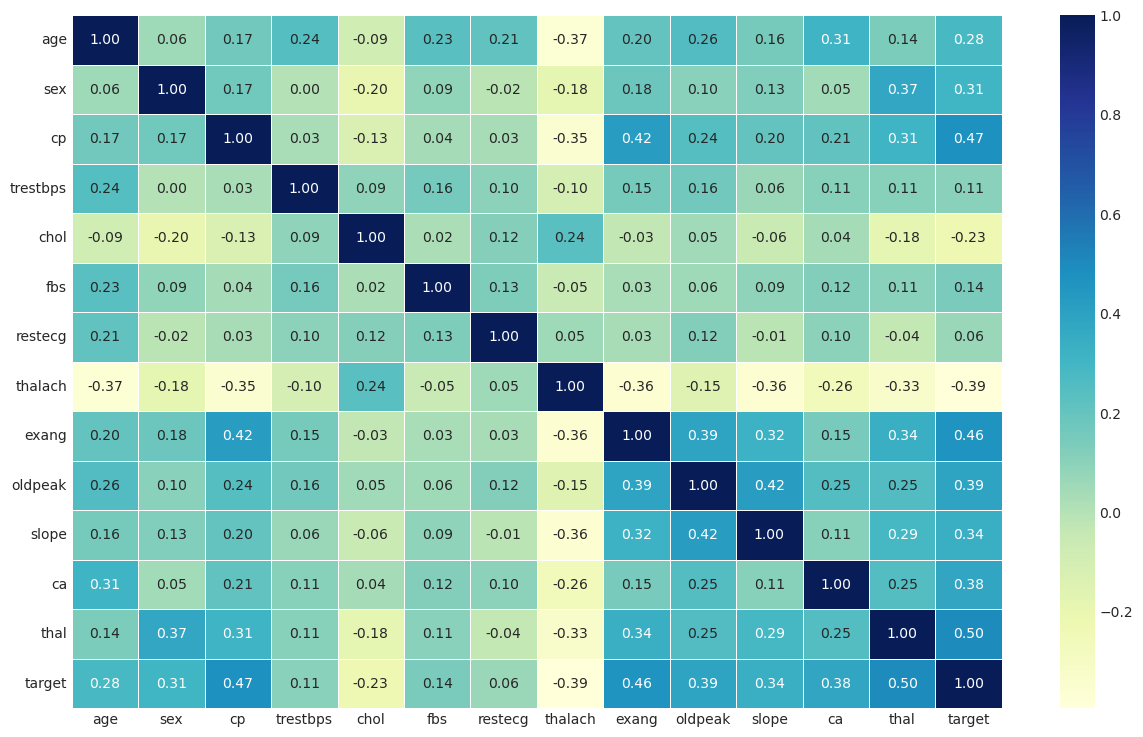

In [40]:
fig, ax = plt.subplots(figsize=(15,9))
sns.heatmap(corr_matrix_all, 
            ax=ax,
            annot=True, 
            linewidths=0.5, 
            fmt= ".2f", 
            cmap="YlGnBu");

#### Start Modelling df_cols_del

##### Fill Missing Values

In [121]:
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
np.random.seed(1995)

results_cols = ["Model Name", "Acc", "Prec", "Recall", "f1"]
results = []

X_cols = df_cols_del.drop(["target"], axis=1)
Y_cols = df_cols_del["target"]

X_train_cols, X_test_cols, y_train_cols, y_test_cols = train_test_split(X_cols, Y_cols,
                                                                        test_size = 0.2) 
mean_imputer = SimpleImputer(strategy="mean")
#ca_imputer = SimpleImputer(strategy="constant", fill_value=9)
imputer = ColumnTransformer([("mean_imputer",  mean_imputer, ["trestbps", "chol", "oldpeak", "thalach"])])

# Fill train and test values separately
filled_X_train_cols = imputer.fit_transform(X_train_cols)
filled_X_test_cols = imputer.transform(X_test_cols)

##### Use Grid Search

In [62]:
# Use Grid search to find best hyperparameters
np.random.seed(1995)

X_cols = df_cols_del.drop(["target"], axis=1)
Y_cols = df_cols_del["target"]

X_train_cols, X_test_cols, y_train_cols, y_test_cols = train_test_split(X_cols, Y_cols,
                                                                        test_size = 0.2)
log_reg_grid = {"C": np.logspace(-4, 4, 20),
                "solver": ["liblinear"]}
gs_log_reg_cols = GridSearchCV(LogisticRegression(),
                          param_grid=log_reg_grid,
                          cv=5,
                          verbose=True)
gs_log_reg_cols.fit(filled_X_train_cols, y_train_cols);

Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [118]:
print(gs_log_reg_cols.best_params_)
cols_preds = gs_log_reg_cols.predict(filled_X_test_cols)

{'C': 206.913808111479, 'solver': 'liblinear'}


In [122]:
acc_cols = gs_log_reg_cols.score(filled_X_test_cols, y_test_cols)
prec_cols = precision_score(y_test_cols, cols_preds)
recall_cols = recall_score(y_test_cols, cols_preds)
f1_cols = f1_score(y_test_cols, cols_preds)

print("Cols Acc: ", acc_cols)
print("\nCols Precision: ", prec_cols)
print("\nCols Recall: ", recall_rows)
print("\nCols F1: ", f1_cols)

#results.append(["df_cols_del", acc_cols, prec_cols, recall_cols, f1_cols])
results[0] = ["df_cols_del", acc_cols, prec_cols, recall_cols, f1_cols]

Cols Acc:  0.7554347826086957

Cols Precision:  0.7431192660550459

Cols Recall:  0.8214285714285714

Cols F1:  0.782608695652174
[['df_cols_del', 0.7554347826086957, 0.7431192660550459, 0.826530612244898, 0.782608695652174]]


#### Start Modelling df_rows_del

In [67]:
#### Start Modelling df_rows_del
np.random.seed(1995)

X_rows = df_rows_del.drop(["target"], axis=1)
Y_rows = df_rows_del["target"]

X_train_rows, X_test_rows, y_train_rows, y_test_rows = train_test_split(X_rows, Y_rows,
                                                                        test_size = 0.2)
gs_log_reg_rows = GridSearchCV(LogisticRegression(),
                          param_grid=log_reg_grid,
                          cv=5,
                          verbose=True)
gs_log_reg_rows.fit(X_train_rows, y_train_rows);

Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [113]:
print(gs_log_reg_rows.best_params_)
rows_preds = gs_log_reg_rows.predict(X_test_rows)

{'C': 1438.44988828766, 'solver': 'liblinear'}


In [123]:
acc_rows = gs_log_reg_rows.score(X_test_rows, y_test_rows)
prec_rows = precision_score(y_test_rows, rows_preds)
recall_rows = recall_score(y_test_rows, rows_preds)
f1_rows = f1_score(y_test_rows, rows_preds)

print("Rows Acc: ", acc_rows)
print("\nRows Precision: ", prec_rows)
print("\nRows Recall: ", recall_rows)
print("\nRows F1: ", f1_rows)

#results.append(["df_rows_del", acc_rows, prec_rows, recall_rows, f1_rows])
results[1] = ["df_rows_del", acc_rows, prec_rows, recall_rows, f1_rows]

Rows Acc:  0.7833333333333333

Rows Precision:  0.7419354838709677

Rows Recall:  0.8214285714285714

Rows F1:  0.7796610169491526


#### Start Modelling crosstab_cp_original

In [95]:
#### Start Modelling crosstab_cp_original
np.random.seed(1995)

X_orig = df_original.drop(["target"], axis=1)
Y_orig = df_original["target"]

X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X_orig, Y_orig,
                                                                        test_size = 0.2)
gs_log_reg_orig = GridSearchCV(LogisticRegression(),
                          param_grid=log_reg_grid,
                          cv=5,
                          verbose=True)
gs_log_reg_orig.fit(X_train_orig, y_train_orig);

Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [107]:
gs_log_reg_orig.best_params_
orig_preds = gs_log_reg_orig.predict(X_test_orig)
print(gs_log_reg_orig.best_params_)

{'C': 0.615848211066026, 'solver': 'liblinear'}


In [124]:
acc_orig = gs_log_reg_orig.score(X_test_orig, y_test_orig)
prec_orig = precision_score(y_test_orig, orig_preds)
recall_orig = recall_score(y_test_orig, orig_preds)
f1_orig = f1_score(y_test_orig, orig_preds)

print("Orig Acc: ", acc_orig)
print("\nOrig Precision: ", prec_orig)
print("\nOrig Recall: ", recall_orig)
print("\nOrig F1: ", f1_orig)

#results.append(["df_original", acc_orig, prec_orig, recall_orig, f1_orig])
results[2] = ["df_original", acc_orig, prec_orig, recall_orig, f1_orig]

Orig Acc:  0.7868852459016393

Orig Precision:  0.7073170731707317

Orig Recall:  0.9666666666666667

Orig F1:  0.8169014084507042


#### Start Modelling crosstab_cp_original - cols

In [102]:
#### Start Modelling crosstab_cp_original - cols ["trestbps", "chol", "thalach"]
np.random.seed(1995)

X_orig_drp = df_original.drop(["target", "trestbps", "chol", "thalach"], axis=1)
Y_orig_drp = df_original["target"]

X_train_orig_drp, X_test_orig_drp, y_train_orig_drp, y_test_orig_drp = train_test_split(X_orig_drp, Y_orig_drp,
                                                                        test_size = 0.2)
gs_log_reg_orig_drp = GridSearchCV(LogisticRegression(),
                          param_grid=log_reg_grid,
                          cv=5,
                          verbose=True)
gs_log_reg_orig_drp.fit(X_train_orig_drp, y_train_orig_drp);

Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [103]:
orig_drp_params = gs_log_reg_orig_drp.best_params_
orig_drp_preds = gs_log_reg_orig_drp.predict(X_test_orig_drp)
print(orig_drp_params)

{'C': 78.47599703514607, 'solver': 'liblinear'}


In [127]:
acc_orig_drp = gs_log_reg_orig_drp.score(X_test_orig_drp, y_test_orig_drp)
prec_orig_drp = precision_score(y_test_orig_drp, orig_drp_preds)
recall_orig_drp = recall_score(y_test_orig_drp, orig_drp_preds)
f1_orig_drp = f1_score(y_test_orig_drp, orig_drp_preds)

print("Orig_drp Acc: ", acc_orig_drp)
print("\nOrig_drp Precision: ", prec_orig_drp)
print("\nOrig_drp Recall: ", recall_orig_drp)
print("\nOrig_drp F1: ", f1_orig_drp)

#results.append(["orig_drp", acc_orig_drp, prec_orig_drp, recall_orig_drp, f1_orig_drp])
results[3] = ["orig_drp", acc_orig_drp, prec_orig_drp, recall_orig_drp, f1_orig_drp]

Orig_drp Acc:  0.7868852459016393

Orig_drp Precision:  0.7073170731707317

Orig_drp Recall:  0.9666666666666667

Orig_drp F1:  0.8169014084507042


#### Comparing Results

In [146]:
results_df = pd.DataFrame(data=results, columns=results_cols).set_index("Model Name")
results_T = results_df.T
results_T

Model Name,df_cols_del,df_rows_del,df_original,orig_drp
Acc,0.755435,0.783333,0.786885,0.786885
Prec,0.743119,0.741935,0.707317,0.707317
Recall,0.826531,0.821429,0.966667,0.966667
f1,0.782609,0.779661,0.816901,0.816901


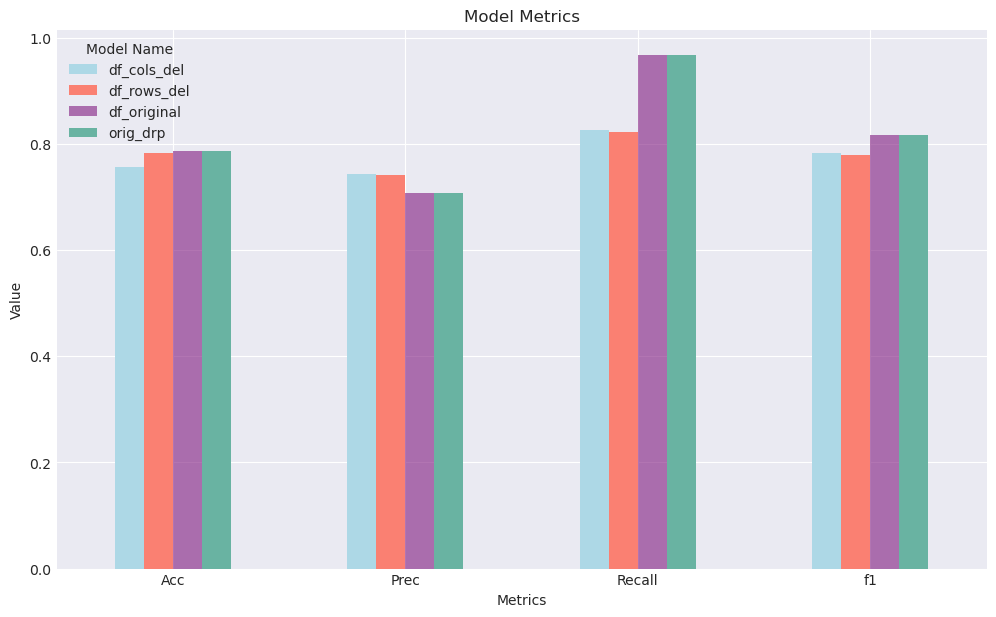

In [158]:
fig, ax1 = plt.subplots(figsize=(12,7))

results_df.transpose().plot.bar( ax=ax1, rot=0,
         title="Model Metrics",
         xlabel="Metrics",
         ylabel="Value",
         legend=True,
         color=["lightblue", "salmon", (0.5,0.1,0.5,0.6), '#69b3a2']);

#### Compare TP, TN, FP, FN

In [ ]:
#### TP TN FP FN

# Final Results

Finally, the best model so far based on *Recall, Accurancy,* and *F1* is the **original** dataset (303 rows).
  -  Acc: 78.69%
  -  Recall: 96.67%
  -  F1: 81.69%

The best model based on *Precision* is the **New/Full dataset** with the columns removed (920 rows).  
The score is **74.31%** vs 70.73% of the original data set. 


In [160]:
len(df_cols_del)

920